### DS3001 Final Paper: Using ML to Predict March Madness Tournament Runs

Luke McMeans (@McMeans), Nithil Suresh (@Nithil-Suresh), Bay Wiggins (@baywigg)

##### Abstract

##### Introduction

##### Data

The dataset we chose to analyze is the KenPom Barttorvik set from Kaggle's March Madness Data. This dataset provides statistics for each team in the NCAA Division 1 Men's Basketball Tournaments from 2008 to 2024. With these teams, their statistics detail their seeding, the furthest round they played, and a large selection of advanced data which can be found in the KenPom and Barttorvik ratings at the time for each respective tournament.

We intended to find trends in the data to see who has the best odds of making deep runs in the tournament (and even winning it all). To do this, we planned to build a predictive model that will scrape from the KenPom rating website. KenPom Ratings have been well respected in the statstic world of college basketball, and are a common tool to find trends in who are the likely favorite to win the championship. For example, all national champions since 2002 (except for two) have been inside the top 20 for adjusted offensive and defensive efficiency. We wanted to apply these phenonemon to a Machine Learning level to get a truly in-depth analysis and find underlying trends in the data. Barttorvik Rating will be a valuable addtion to this analysis, as they provide similar insights that can reinforce our findings (along with being easier to access online). Given the prestige of these statistics and their application to the college basketball world, we are confident these sources will prove to be the strongest set of data to predict succesful teams for any given March

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
df = pd.read_csv('./raw_data/kenpom_barttorvik_raw.csv')
df


,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK
0,2025,MAC,17,66,2,1147,2,Akron,13,64,...,19,361,364,73,149,86,239,25,145,305
1,2025,SEC,28,66,2,1146,3,Alabama,2,8,...,1,57,4,261,32,211,92,9,174,1
2,2025,SWAC,31,68,4,1145,4,Alabama St.,16,64,...,154,285,239,83,251,270,61,227,147,253
3,2025,Pat,25,66,2,1144,6,American,16,68,...,349,303,248,181,364,58,34,218,163,329
4,2025,B12,7,66,2,1143,8,Arizona,4,16,...,52,74,129,225,16,18,143,25,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,2008,BE,8,1,1,5,235,West Virginia,7,16,...,225,18,115,181,61,209,16,22,32,49
1143,2008,SB,26,1,1,4,236,Western Kentucky,12,16,...,111,160,179,55,131,127,214,27,28,203
1144,2008,BSth,10,4,4,3,239,Winthrop,13,64,...,301,231,206,89,236,339,190,170,12,179
1145,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,301,51,35,98,12,118,117,60,2,57


Since this came from Kaggle, the data is mostly clean. We just need to make some minor changes, like dropping columns and adjusting column names. For the columns, we'll focus on what is easily accessible to the KenPom and Barttovik sites. This leaves us with these 47 columns...

- `year`: year of the tournament
- `team`: the team name
- `team_id`: the unique identifier for the team (tranfers over from year to year)
- `conf`: the conference of the team
- `quad_id`: the quadrant that the team is in
- `seed`: the seeding of the team that year
- `round`: the furthest round the team went

The following columns also have a 'rank' column associated with them, which signals their placement amongst all D1 teams that year...
- `kadj_o`: KenPom adjusted offensive efficiency
- `kadj_d`: KenPom adjusted defensive efficiency
- `kadj_t`: KenPom adjusted tempo (possessions per 40 minutes)
- `badj_o`: Barttorvik adjusted offensive efficiency
- `badj_d`: Barttorvik adjusted defensive efficiency
- `barthag`: Barttorvik power rating (chance of beating average D1 team)
- `efg%`: effective field goal percent
- `efg%d`: opponent's effective field goal percent
- `tov%`: turnover percent
- `tov%d`: opponent's turnover percent
- `oreb%`: offensive rebound percent
- `dreb%`: defensive rebound percent
- `ftr`: ratio of free throw attempts to field goal attempts
- `ftrd`: opponent's ratio of free throw attemps to field goal attempts
- `2pt%`: two point field goal percent
- `2pt%d`: opponent's two point field goal percent
- `3pt%`: three point field goal percent
- `3pt%d`: opponent's three point field goal percent
- `3ptr`: percentage of shots being three pointers
- `3ptrd`: opponent's percentage of shots being three pointers

In [4]:
# convert columns to lowercase, replacing spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# get columns to keep and assign them to the dataframe
kept_cols = ['year', 'team', 'team_id', 'conf', 'quad_id', 'seed', 'round',
             'kadj_o', 'kadj_o_rank', 'kadj_d', 'kadj_d_rank', 'kadj_t', 'kadj_t_rank',
             'badj_o', 'badj_o_rank', 'badj_d', 'badj_d_rank', 'barthag', 'barthag_rank',
             'efg%', 'efg%_rank', 'efg%d', 'efgd%_rank', 'tov%', 'tov%_rank',
             'tov%d', 'tov%d_rank', 'oreb%', 'oreb%_rank', 'dreb%', 'dreb%_rank',
             'ftr', 'ftr_rank', 'ftrd', 'ftrd_rank', '2pt%', '2pt%_rank',
             '2pt%d', '2pt%d_rank', '3pt%', '3pt%_rank', '3pt%d', '3pt%d_rank',
             '3ptr', '3ptr_rank', '3ptrd', '3ptrd_rank']
df = df[kept_cols]
df

,year,team,team_id,conf,quad_id,seed,round,kadj_o,kadj_o_rank,kadj_d,...,2pt%d,2pt%d_rank,3pt%,3pt%_rank,3pt%d,3pt%d_rank,3ptr,3ptr_rank,3ptrd,3ptrd_rank
0,2025,Akron,2,MAC,2,13,64,113.7490,66,107.1760,...,50.6,171,36.6,52,31.9,75,45.4,52,38.0,152
1,2025,Alabama,3,SEC,2,2,8,126.5980,4,96.6919,...,48.8,96,35.0,116,30.8,32,46.2,43,35.1,59
2,2025,Alabama St.,4,SWAC,4,16,64,101.4540,271,110.6890,...,50.4,158,32.9,224,33.4,160,42.9,85,39.5,206
3,2025,American,6,Pat,2,16,68,102.0950,253,108.0710,...,53.1,270,35.1,106,33.6,171,44.8,58,35.7,80
4,2025,Arizona,8,B12,2,4,16,122.5670,13,96.8244,...,47.2,43,32.4,250,33.6,171,34.6,295,41.9,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,2008,West Virginia,235,BE,1,7,16,113.5700,33,93.4302,...,45.1,55,35.8,142,35.4,188,35.0,155,32.1,98
1143,2008,Western Kentucky,236,SB,1,12,16,111.0760,54,97.0110,...,46.0,80,38.6,34,32.5,48,32.4,211,31.6,87
1144,2008,Winthrop,239,BSth,4,13,64,99.6932,230,92.3864,...,45.8,76,37.4,79,31.0,23,31.7,231,42.8,332
1145,2008,Wisconsin,240,B10,3,3,16,113.6190,32,86.2081,...,41.3,5,35.9,135,31.1,24,31.1,246,32.8,122


**EDA on NCAA Conferences**


Top 10 conferences that have had the most bids in the NCAA tournament. Each conference sends at least one team to the tournament every year, some conferences get to send more based on the strength of the teams in the conference.


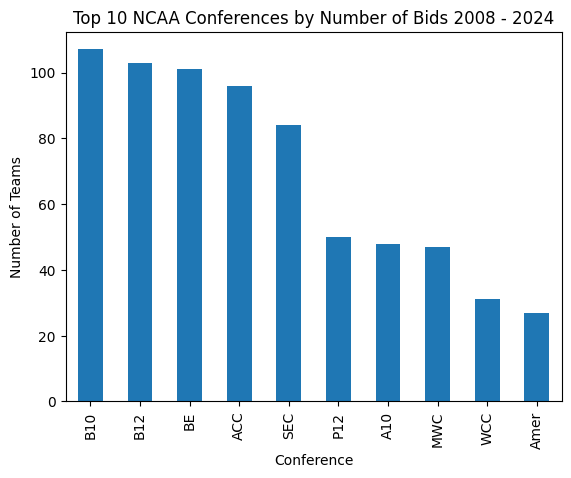

**EDA on Kenpom's Adjusted Offensive Efficiency**

In [13]:
df['kadj_o'].describe()

count    1147.000000
mean      112.043686
std         6.117141
min        90.890400
25%       108.300500
50%       112.303000
75%       116.296000
max       128.505000
Name: kadj_o, dtype: float64

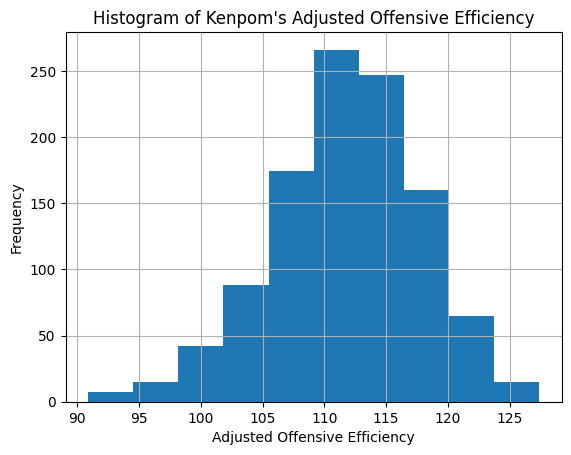

##### Methods

##### Conclusion

##### References